# Tutorial 6 - Least squares and minumum norm inversions
We now return to the inverse problem illustrated in outline within Tutorial 1 explaining the ideas and methods in fuller detail. In this tutorial we restrict attention to the solution of the inverse problem using the minimum norm method, with the Bayesian approach discussed in Tutorial 7. 

### Setting up the forward problem

Recall that within our problem we are given data
$$
v_{i} = u(\theta_{i}) +z_{i}, \quad i = 1,\dots, n,
$$
where $u \in H^{s}(\mathbb{S}^{1})$ for $s > 1/2$ is an unknown function, the $\theta_{i}$ are given angles, and $z_{i}$ random errors. While the constraint on the Sobolev exponent is necessary for point-evaluation to be well-defined, neither the precise value of $s$ nor of the length-scale paramater $\lambda>0$ occurring within the definition of the Sobolev space are provided. As a result, we should examine later how these choices effect the solutions obtained. 

For the random errors, we will assume more concretely that the $z_{i}$ are components of a random vector $z \sim \mathcal{N}_{\mathbb{R}^{n}}(0, R)$. In Tutorial 1 we took the covariance matrix to be proportional to the identity (and hence used ```from_standard_deviation``` to construct the associated ```GaussianMeasure```), but now we allow it to take a more general form. While the expectation of the error term is still taken to be zero - and in practice this the data can always be corrected such that this is true - the methods discussed can also handle the more general case if desired. 


To proceed, we first set up the model space:

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pygeoinf as inf
from pygeoinf.homogeneous_space.circle import Sobolev

# Set the Sobolev parameters for the model space. 
exponent = 2.0
length_scale = 0.1

# Set the model space. 
model_space = Sobolev.from_sobolev_parameters(exponent, length_scale, power_of_two=True)

print(f'The discretised model space has dimension: {model_space.dim}')

The discretised model space has dimension: 2048


Note that we have used the static method ```from_sobolev_parameters``` to select an appropriate discretisation of the model space. In this case, we have set the optional argument ```power_of_two``` to be ```True```. This ensures that the discretised model space has a dimension $2^{m}$ for some $m$. Doing this aids efficiency within fast Fourier transformations. 

To get the forward operator, we can use the method ```point_evaluation_operator``` that is built into the Sobolev class. To form this operator, we just need to provide a list of the observation points and the corresponding ```LinearOperator``` is returned. The codomain of this operator is the appropriately dimensioned ```EuclideanSpace``` which we store as the data space for our problem. 

In [32]:
# Set up the observation points. 
n = 15
observation_points = np.random.uniform(0, 2*np.pi, n)

# Set the forward operator
forward_operator = model_space.point_evaluation_operator(observation_points)

# Set the data space. 
data_space = forward_operator.codomain

print(f'The data space has dimension: {data_space.dim}')

The data space has dimension: 15


We now need to define the data error measure. To proceed, we will assume that these errors arise from an underlying Gaussian measure, with this being a convenient method for generating errors with a non-diagonal covariance matrix. In code below we first set up such a measure on the model space with non-zero mean. This can be pushed forward using the forward operator to form the data error measure. An issue, however, is that the resulting measure does not have its inverse covariance defined, nor a sampling method set up, both of which we later require. To proceed, we can extract the measure's covariance matrix in dense form and use this to construct our final data error measure. 

In [33]:
# First define a Gaussian measure on the model space. 
error_length_scale = 0.2
error_amplitude = 0.1
mu = model_space.heat_gaussian_measure(error_length_scale, error_amplitude)

# Push forward the measure under the forward operator. 
nu = mu.affine_mapping(operator=forward_operator)

# Extract the covariance matrix and use this to define the desired measure. 
covariance_matrix = nu.covariance.matrix(dense=True)
data_error_measure = inf.GaussianMeasure.from_covariance_matrix(data_space, covariance_matrix)

# Get the standard deviations for each datum for use in plotting. 
standard_deviations = np.zeros(data_space.dim)
for i in range(data_space.dim):
    v = data_space.basis_vector(i)
    standard_deviations = np.sqrt(data_space.inner_product(data_error_measure.covariance(v), v))

We are now in a position to set up our forward problem, this being described by an instance of the class ```LinearForwardProblem```. Construction of this object requires us to pass the ```forward_operator``` and the ```data_error_measure```. The second argument is optional with default ```None``` in which case the data are assumed to be error-free.

In [34]:
# Set the forward problem. 
forward_problem = inf.LinearForwardProblem(forward_operator, data_error_measure)

The ```LinearForwardProblem``` class has, in of itself, relatively little functionality. It does, however, provides useful methods for generating synthetic data. One is called ```synthetic_data```, takes in a model as argument, and returns the corresponding data. If a data error measure has been set, then sampled values for the data errors are added to the result of the forward operator. Below we directly define a model and use ```synthetic_data``` to generate corresponding data. We also make use of a simple method within the  ```Sobolev``` class for plotting its elements. 

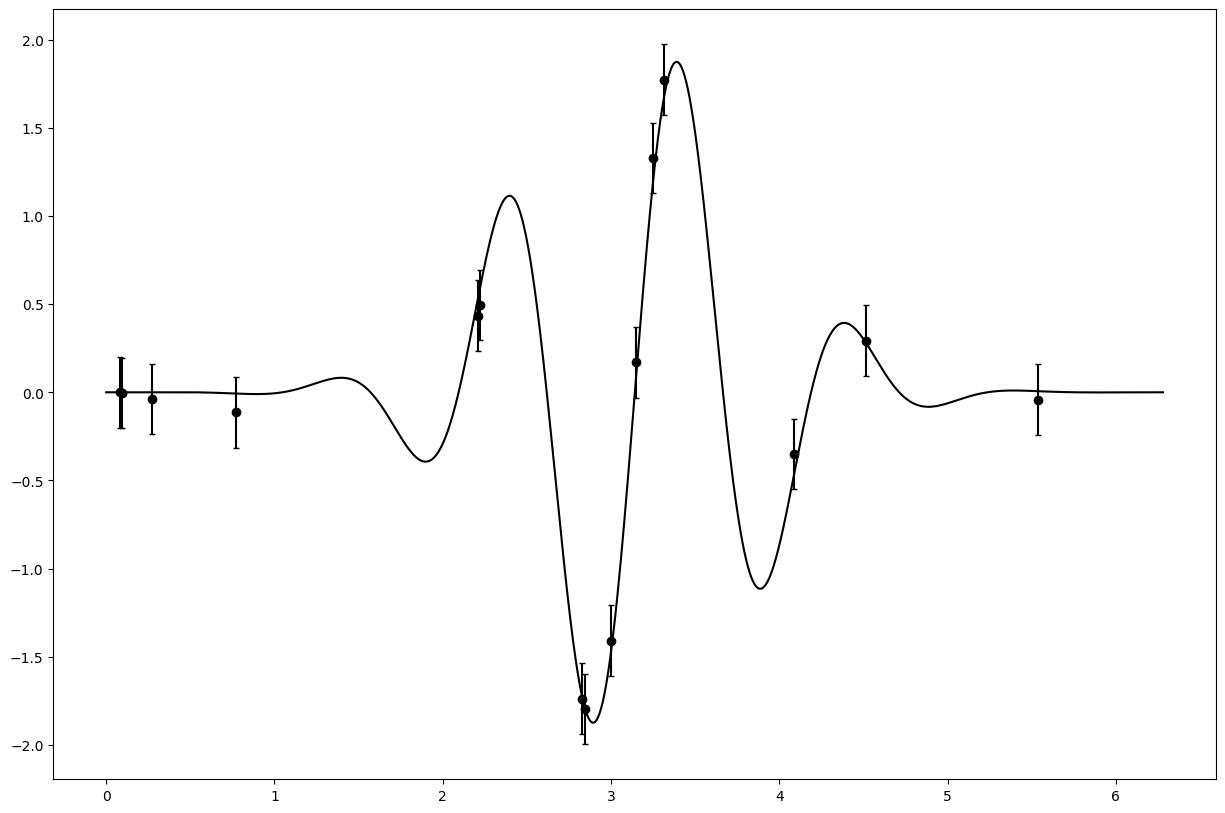

In [35]:
# Set the function directly. 
model = model_space.project_function(lambda th: 2* np.sin(6*th) * np.exp(-(th-np.pi)**2) )

# Generate the synthetic data
data = forward_problem.synthetic_data(model)

# Plot the model and associated data. 
fig, ax = model_space.plot(model, color="k", figsize=(15, 10))
ax.errorbar(observation_points, data, 2 * standard_deviations, fmt="ko", capsize=2)
plt.show()

The ```LinearForwardProblem``` class also provided methods related to the chi-squared statistic that can be used to assess the compatibility of a given model with data. To use these methods it is necessary that a data error measure is provided and that it has its inverse covariance set. These ideas are illustrated below:

In [36]:
# Set the desired significance level
significance_level = 0.95

# Get the critical chi-squared value.
critical_chi_squared = forward_problem.crtical_chi_squared(significance_level)
print(f'The critical chi-squared value is: {critical_chi_squared}')

# Get the chi-squared for the true model
chi_squared = forward_problem.chi_squared(model, data)
print(f'The chi-squared for the true model is: {chi_squared}')

# Check if the model is compatible with the data. 
print(f'Is the chi-squared test passed for the true model: {forward_problem.chi_squared_test(significance_level, model, data)}')


# Repeat the checks using a difference model 
new_model = 2 * model
chi_squared = forward_problem.chi_squared(new_model, data)
print(f'The chi-squared for the new model is: {chi_squared}')
print(f'Is the chi-squared test passed for the new model: {forward_problem.chi_squared_test(significance_level, new_model, data)}')


The critical chi-squared value is: 24.995790139728616
The chi-squared for the true model is: 6.82614296510944
Is the chi-squared test passed for the true model: True
The chi-squared for the new model is: 1481.3563176294347
Is the chi-squared test passed for the new model: False


### Least squares inversions

As a step towards understanding minimum norm solutions of the inverse problem, we begin with the **regularised  least squares method**. The aim here is to minimise
$$
J = \left(R^{-1}(Au + \overline{z} - v),Au + \overline{z} - v \right)_{Y} + \mu\|u\|_{X}^{2}, 
$$
where we write $X$ for the model space, $Y$ for the data space, and $\mu>0$ is a damping parameter. Note that the first term is equal to the
$\chi^{2}$ statistic.  This quadratic functional has a unique minimum point
at the model defined through the  **normal equations**:
$$
(A^{*}R^{-1}A+\mu) u = A^{*}R^{-1}v. 
$$
 

This problem can be solved using the ```LinearLeastSquaresInversion``` class. To construct an instance, we need only provide the forward problem:

In [37]:
least_squares_inversion = inf.LinearLeastSquaresInversion(forward_problem)

From this object we can, for example, obtain the normal operator, $A^{*}R^{-1}A+\mu$ for a given damping parameter. Extraction of this operator can be useful when, for example, building a pre-conditioner for the solution of the normal equations. 

In [38]:
damping_parameter = 0.1
normal_operator = least_squares_inversion.normal_operator(damping_parameter)

To obtain the least squares solution we need to solve a linear equation involving the normal operator. To proceed, we need to introduce the ```LinearSolver``` class. Each linear solver is derived from this abstract base class and must provide  a ```__call__``` method that takes in a ```LinearOperator``` and outputs its inverse as  a new ```LinearOperator```. There are two types of ```LinearSolver```, namely ```DirectLinearSolver``` and ```IterativeLinearSolver```. 


In the case of ```DirectLinearSolver``` a dense matrix representation of the operator is formed and used to constructe the inverse operator. This can either be based on the standard or Galerkin matrix representation. The methods currently implemented are:

- ```LUSolver```: Based on the ```scipy``` implementation of LU factorisation and backsubstitution. Applies to general operators. 
- ```CholeskySolver```: Based on the ```scipy``` implementation of Cholesky factorisation and backsubstitution. Requires the operator's matrix representation be symmetric and positive-definite. 


Solvers derived from ```IterativeLinearSolver``` are matrix-free and generally better for linear equations on high-dimensional spaces. The ```__call__``` method in these cases can optionally be provided with a predconditioner, this being a ```LinearOperator``` that acts as an approximate inverse of the desired operator. The iterative solvers available are:

- ```CGMatrixSolver```: Based on the ```scipy``` implementation of the conjugate gradient method. Requires the operator's matrix representation be symmetric and positive-definite. 
- ```BICGMatrixSolver```: Based on the ```scipy``` implementation of the biconjugate gradient method. 
- ```BICGStabMatrixSolver```: Based on the ```scipy``` implementatoin of the stabilised biconjugate gradient method. 
- ```GMRESMatrixSolver```: Based on the ```scipy``` implementation of the generalised minimum residual method. 
- ```CGSolver```: An implementation of the conjugate gradient method directly on the operators domain. Requires the operator to be self-adjoint and positive-definite. 

Note that the methods based on ```scipy``` solvers rely on a matrix-representation of the operator, but do not need this to be formed as a dense matrix. 

In the code below, we determine the solution of the least squares problem using either a ```CholeskySolver``` or the matrix-free ```CGSolver``` method. Note that for the Cholesky method we set the optional ```galerkin``` argument to ```True```. This is to ensure that the matrix representation used is symmetric and positive-definite. 

It should be seen that the iterative method is faster and is more robust for small values of the damping parameter (in which case the operator becomes poorly conditioned). Indeed, it is important that ```CGSolver``` works directly on the Sobolev space using the correct inner product. This leads to a far better conditioned linear system that those that rely on either matrix representation. 

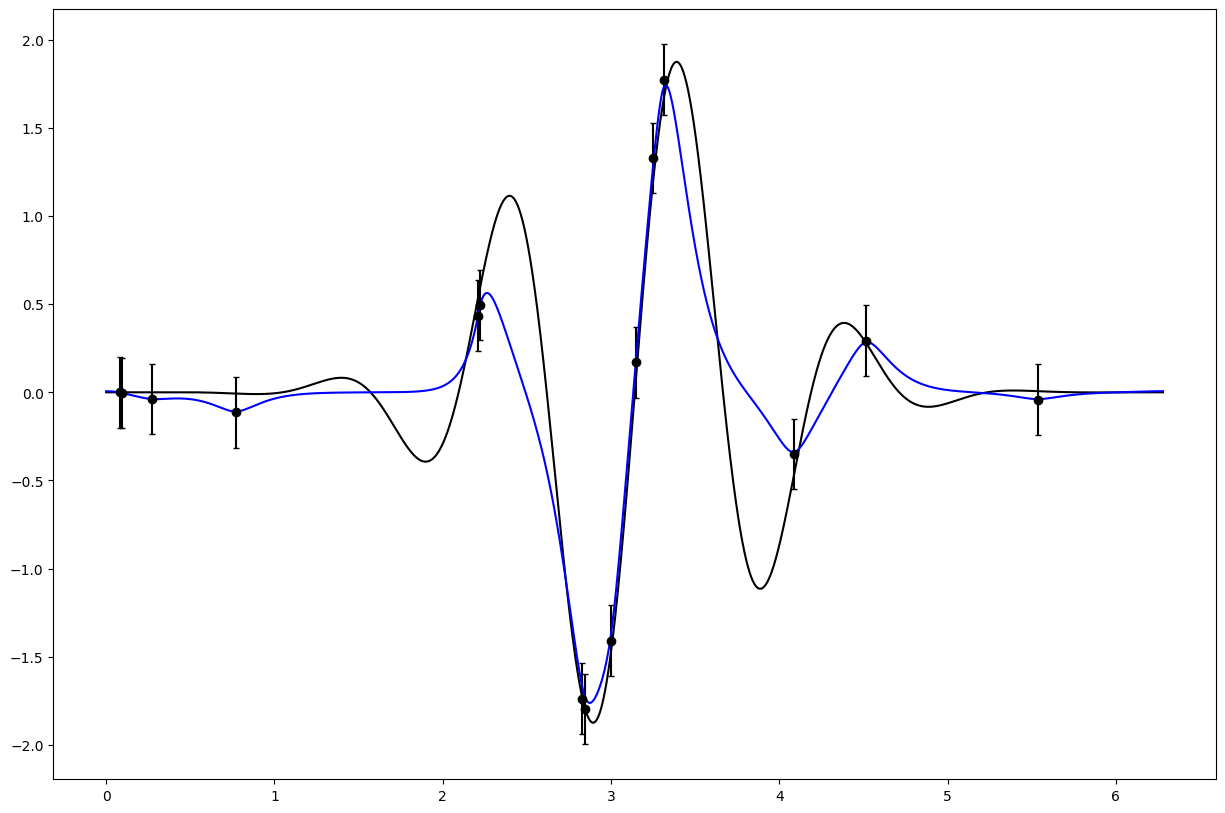

In [39]:
# Set the solution method "direct" or "iterative"
method = "iterative"

if method == "direct":
    # Set up the Cholesky solver based on the Galerkin representation. 
    solver = inf.CholeskySolver(galerkin=True)
elif method == "iterative":
    # Set up the Conjugate gradient solver directly on the model space. rtol is 
    # the relative tolerance applied, with the default being 1e-5. 
    solver = inf.CGSolver(rtol=1e-8)    
else:
    raise ValueError("Invald option")

# Form the least squares operator. Note the use of the Galerkin matrix representation. 
damping_parameter = 10
least_squares_operator = least_squares_inversion.least_squares_operator(damping_parameter,solver)

# Obtain the solution. 
least_squares_model = least_squares_operator(data)

# Plot the model and associated data and the least squares solution.
fig, ax = model_space.plot(model, color="k", figsize=(15, 10))
ax.errorbar(observation_points, data , 2 * standard_deviations, fmt="ko", capsize=2)
model_space.plot(least_squares_model, color="b", fig=fig, ax=ax)
plt.show()

It is worth noting that the method ```least_squares_operator``` returns an instance of the ```Operator``` class that is used for general mappings between Hilbert spaces. The ```LinearOperator``` class is derived from ```Operator``` and has significantly more strucutre. The reason is that the solution of the least squares problem does not depend linearly on the data. Rather, the relationship is affine, with the translation term being associated with the expectation of the data error measure. In the error-free case, a ```LinearOperator``` is returned by this method. 

### Minimum norm inversions

A well-known issue with regularised least squares is how an appropriate value for the damping parameter should be selected. Various methods have been proposed to do this but ultimately the question is not sensible. There is no *best* choice of damping parameter without additional information being provided. 

An alternative method that is more satisfactory is to seek a **minimum norm solution** of the problem. In outline, this method seeks from amougst all those models that are statistically compatible with the data the one with the smallest norm. It can be shown that if there are *any* models that are compatible with the data, then there is a unique one with minimum norm. Note that an equivalent name for this method is an **Occam inversion** as discussed by Constable, Parker, and Constable (1987).


Determination of the minimum norm soltuion proceeds as follows:

- A significance level, $\alpha$, is selected for the $\chi^{2}$-test. From this a critical value, $\chi_{0}^{2}$, of the test statistic is determined, with a model being compatible with the data if and only if its $\chi^{2}$-value is less than or equal to $\chi_{0}^{2}$.
- The zero-model is tested for compatibility with the data. If its $\chi^{2}$ is sufficient small then it is the unique minimum norm model. 
- Otherwise, the minimum norm model is one whose $\chi^{2}$-value is equal to the critical value. 

To determine the model within the third step, we can apply the method of Lagrange multipliers, resulting in the Lagrangian:
$$
L = \|u\|_{X}^{2} + \xi\left[
\left(R^{-1}(Au + \overline{z} - v),Au + \overline{z} - v \right)_{Y} - \chi_{0}^{2}, 
\right]
$$
with $\xi$ a Lagrange multiplier. The resulting stationarity conditions are:
$$
(A^{*}R^{-1}A + \xi^{-1})u = A^{*}R^{-1}(v-\overline{z}), \quad \left(R^{-1}(Au + \overline{z} - v),Au + \overline{z} - v \right)_{Y} = \chi_{0}^{2}.
$$
For fixed $\xi$, the first equation is identical to the least squares normal equations, with $\xi^{-1}$ being the damping parameter. This allows us to solve for $u$ in terms of $\xi$, and hence reduce the second constraint into a scalar equation for $\xi$. Importantly, the resulting function is monotonically decreasing, and hence if it has a solution it can be readily founded using a simple bracketing scheme. 

This process is carried out within the ```LinearMinimumNormInvesion``` class whose use is illustrated below. Note again that the resulting operator that maps from the data to the model space is non-linear and hence an instance of the ```Operator``` class. In this case, additional non-linearity comes from the fact that the optimal value for $\xi$ is dependent on the data. 

Internally, the the action of the  ```minimum_norm_operator``` requires the solution of multiple regularised least squares problems. This is best done with an iterative method that uses the solution of the previous problem as an initial guess. The latter process is facilitated by the ```solve_linear_system``` method within ```IterativeLinearSolvers``` which allows an initial guess to be passed through to the iterative method in addition to the right hand side. 

A key point about the minimum norm method is that it can fail to find a suitable model. This occurs when no element of the model space fits the data acceptably. In practice, this means that as the Lagrange multiplier tends to infinity the associated value of $\chi^{2}$ never drops below the critical value. If the method is run with a 95% significance level, and if our error model is correct, this should happen aroud 5% of the time. In such cases the ```minimum_norm_operator``` raises a ```RuntimeError```. We account for this below through a simple use of exception handling. 

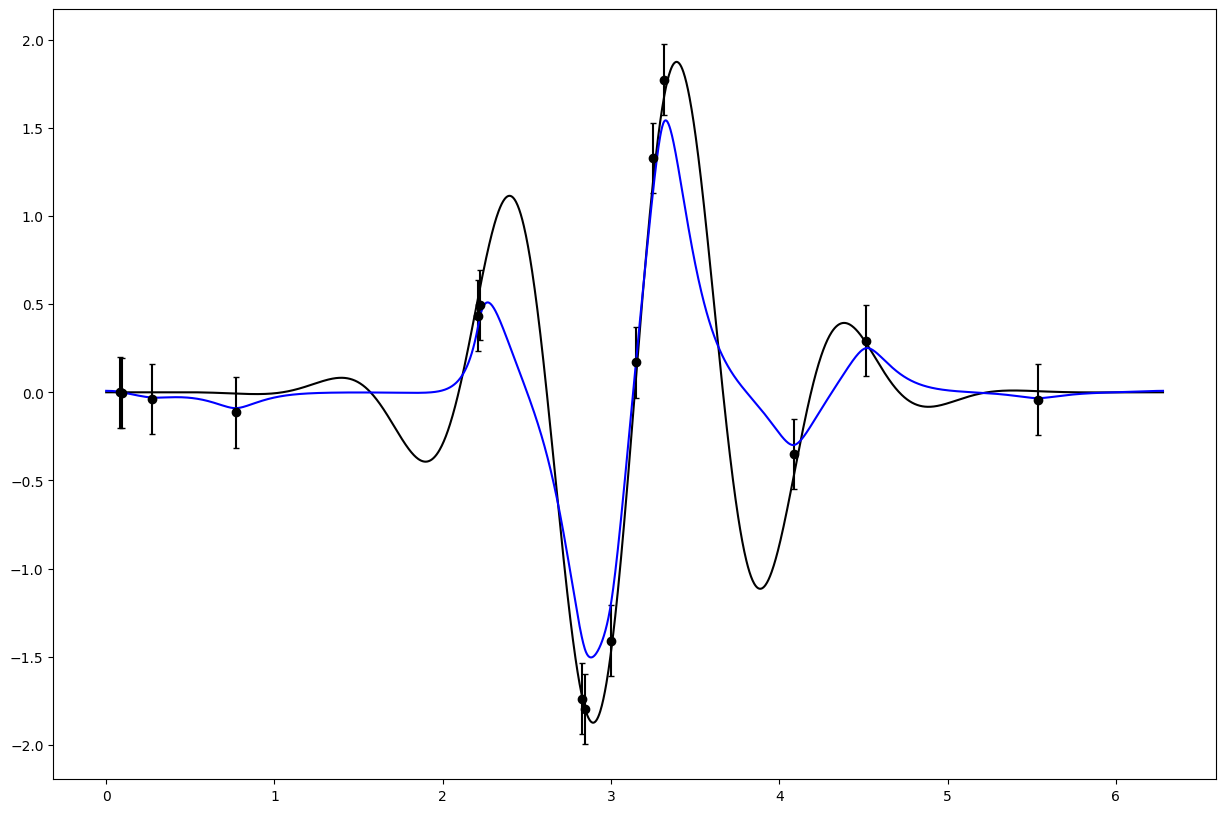

In [40]:
# Set up the inversion scheme. 
minimum_norm_inversion = inf.LinearMinimumNormInversion(forward_problem)

# Set the necessary options. 
significance_level = 0.95
solver = inf.CGSolver(rtol=1e-8)

# Set up the operator from the data to model spaces. 
minimum_norm_operator = minimum_norm_inversion.minimum_norm_operator(solver, significance_level=significance_level)

# Compute and plot the solution. 
try: 
    minimum_norm_model = minimum_norm_operator(data)

    # Plot the model and associated data and the least squares solution.
    fig, ax = model_space.plot(model, color="k", figsize=(15, 10))
    ax.errorbar(observation_points, data , 2 * standard_deviations, fmt="ko", capsize=2)
    model_space.plot(minimum_norm_model, color="b", fig=fig, ax=ax)
    plt.show()

except RuntimeError:
    print(f'Minimum norm solution does not exist')



A clear advantage of the minimum norm solution is the ellimination of the damping parameter. Nonetheless, this is still just one possible solution that is compatible with the data and so it is ultimately of limited value. Later, we will see how minimum norm solutions can be adapted and applied usefully in the solution of associated inference problems. It is also worth emphasising that the minimum norm solutions are defined relative to a particular choice of model space. If, for example, the Sobolev exponent or length-scale is changed, then the minimum norm solution will change correspondingly. These values can be altered and this notebook rerun to see this in practice. 